# 05.06 - Linear Regression

Linear regression models are a great starting point for regression tasks. 

This section provides a simple introduction to the mathematics behind linear regression and applications on how these models can be generalized to account for more complicated patterns in data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

### Simple Linear Regression

The simplest linear regression - a straight line fit to the data - has standard equation in this form:

<code>y = ax + b</code> with a = **slope** and b = **intercept**

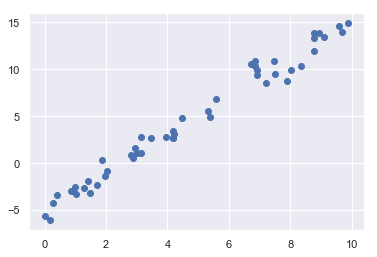

In [2]:
# line with slope = 2 and intercept = -5
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

Scikit-learn built-in <code>LinearRegression</code> can estimate the best-fit line:

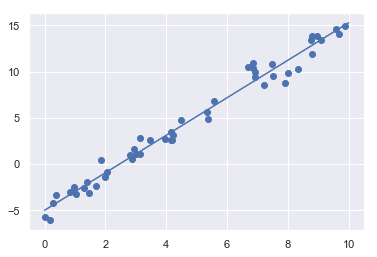

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [4]:
# slope and intercept
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.027208810360694
Model intercept: -4.998577085553198


<code>LinearRegression</code> is also capable of handling multidimensional linear models of the form
<code> y=a0 + a1x1 + a2x2 + ... </code>

Despite being more difficult to visualize, multidimensional data is handled without any issue in Scikit-learn. Let's take for example a made up dataset created in NumPy:

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000011
[ 1.5 -2.   1. ]


### Basis Function Regression

So far, we have worked under the assumption of working on strictly linear relationship between variables.
One way to adapt linear regression to nonlinear relationships is to transform the data according to basis functions.

The idea is to have a specific function _f()_ **transform** our independent variables. 

### Polynomial basis functions

The polynomial projection is built-in Scikit-learn using the <code>PolynomialFeatures<code> transformer:

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by **taking the exponent of each value**. This new, higher-dimensional data representation can then be plugged into a linear regression.

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between x and y. For example, here is a sine wave with noise:

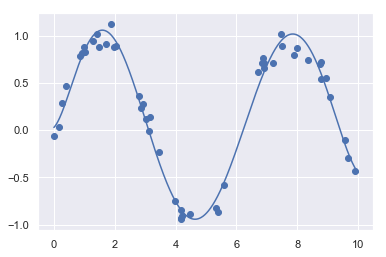

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gaussian basis functions

Of course, we can use other basis function. For example, modelling as a sum of Gaussian bases:

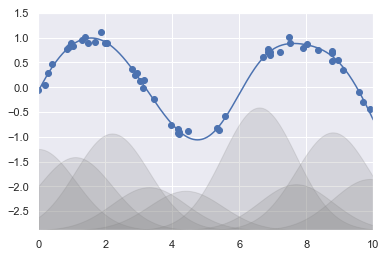

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly-spaced Gaussian Features for 1D input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
xfit = np.linspace(0, 10, 1000)

gauss_model = make_pipeline(GaussianFeatures(10, 1.0),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

gf = gauss_model.named_steps['gaussianfeatures']
lm = gauss_model.named_steps['linearregression']

fig, ax = plt.subplots()

for i in range(10):
    selector = np.zeros(10)
    selector[i] = 1
    Xfit = gf.transform(xfit[:, None]) * selector
    yfit = lm.predict(Xfit)
    ax.fill_between(xfit, yfit.min(), yfit, color='gray', alpha=0.2)

ax.scatter(x, y)
ax.plot(xfit, gauss_model.predict(xfit[:, np.newaxis]))
ax.set_xlim(0, 10)
ax.set_ylim(yfit.min(), 1.5)

fig.savefig('figures/05.06-gaussian-basis.png')

### Regularization

**Ridge Regression / L2 regularization / Tikhonov regularization**

The most common type of regularization works by _penalizing_ the sum of squares of the model coefficients. 

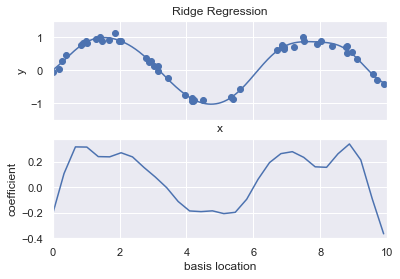

In [12]:
from sklearn.linear_model import Ridge

def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))

model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

**Lasso regularization / L1 regularization**

Lasso regularization involves penalizing the sum of absolute values of regression coefficients.

C:\Users\Giuseppe\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


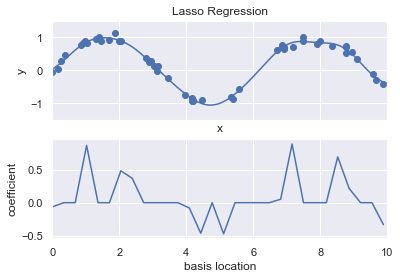

In [13]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

### Example: Predicting Bicycle Traffic

We will reuse our previous dataset on cyclists in Seattle, and combine it with NOAA weather data to understand how a change in temperature, precipitation, and daylight hours affects the volume of bicycle traffic.

In [15]:
import pandas as pd
counts = pd.read_csv('../data/Fremont_Bridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('../data/bicycle_weather.csv', index_col='DATE', parse_dates=True)

In [16]:
# total daily bycicle traffic -> dataframe
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [17]:
# dummy for day of the week
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [18]:
# differentiate holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

(8, 17)

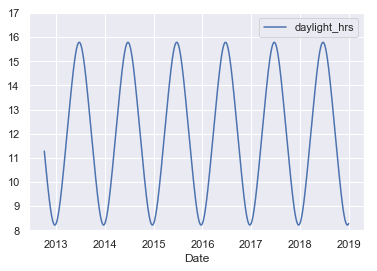

In [19]:
# hours of daylight
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [20]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

# days with no precipitations
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [21]:
# year counter
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [22]:
# data in order
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [23]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

# fit linear regression
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

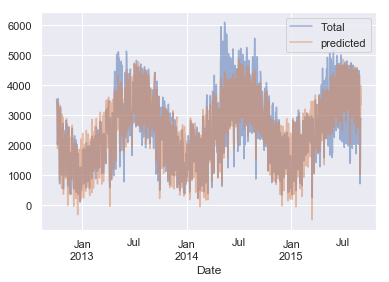

In [24]:
# compare total and predicted traffic
daily[['Total', 'predicted']].plot(alpha=0.5);

We can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [25]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

In [26]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [27]:
# adding errors
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0
